In [108]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), 'deeprad'))
pths = [home]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp 
# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import deeprad.image2vec as i2v
from shapely import affinity
import shapely.geometry as geom

from rtree import index
from sklearn.mixture import GaussianMixture
from copy import copy
import cv2 

figsize_default = np.array((5, 5))

In [112]:
data_num = 10

data_num, targ_ids = i2v.extract_floorplan_ids(data_num)
hdicts, imgs, labels, targ_id_dirs = i2v.load_floorplan_data(targ_ids)

idx = 2
# Extract data
hdict, img, _rooms = hdicts[idx], imgs[idx], labels[idx]
scale = hdict['scale']
doors = hdict['door_vecs']

print(hdict['id'])


floorplan_2014


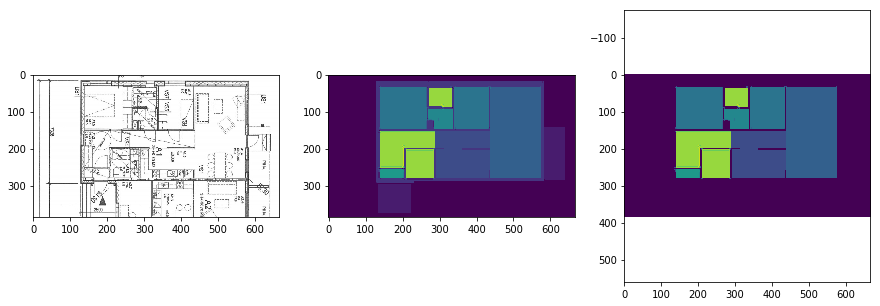

In [114]:
room_classes_idx = np.unique(_rooms)

# remove balconies, railings, and walls
_rooms_orig = copy(_rooms)
_rooms = np.where(_rooms == 1, 0, _rooms)
_rooms = np.where(_rooms == 8, 0, _rooms)
_rooms = np.where(_rooms == 2, 0, _rooms)

# Plot images
_, a = plt.subplots(1, 3, figsize=(figsize_default[0] * 3, figsize_default[1]))
a[1].imshow(_rooms_orig)
a[2].imshow(_rooms)
a[0].imshow(img)
_ = a[2].axis('equal')

bld width: 13.19m


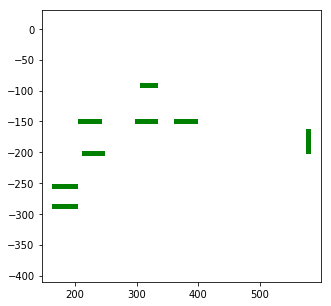

In [116]:
f, a = plt.subplots(1,1, figsize=figsize_default)
door_lens = []
for door in doors:
    pts, label = door[0], door[1]
    pts = np.array(pts) * scale
    door_vec = pts[1] - pts[0]
    door_len = np.sum(door_vec ** 2) ** 0.5
    door_lens.append(door_len)
    X = pts[:, 0]
    Y = -pts[:, 1]
    a.plot(X, Y, 'green', linewidth=5)

a.axis('equal')
door_lens = np.array(door_lens)
meter_scale = 0.9 / door_lens.mean()
image_scale = 1 / meter_scale

# Gut check the scale
_dim = np.where(np.sum(_rooms, axis=0) > 1, 0, 1)
_dim = i2v.contiguous_ones_idx(_dim)
diff = _dim[:, 1] - _dim[:, 0]
diff = np.diff(_dim, n=1, axis=1).ravel()
_dim = _rooms.shape[1] - np.sum(diff)
print('bld width: {}m'.format(np.round(_dim * meter_scale, 2)))


In [118]:
room = _rooms.astype(np.float64)
dx = np.abs(np.diff(room, axis=0, prepend=0.0))
dy = np.abs(np.diff(room, axis=1, prepend=0.0))
diff = dx + dy
diff = np.where(diff > 0, 255, 0)
threshed_rooms = diff.astype(np.uint8)

#_, a = plt.subplots(figsize=figsize_default)
#a.imshow(room)

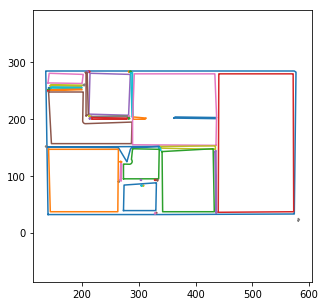

In [119]:

_contour_arr = i2v.contour_arr_from_bit_image(threshed_rooms, threshold=True)[:-1]
_poly_np_arr = [i2v.contour_to_poly_np(contour) 
                for contour in _contour_arr]

# Rescale
#pts_arr = np.array([j for i in _poly_np_arr for j in i.T])
#minx, miny = pts_arr[:, 0].min(), pts_arr[:, 1].min()
#print(minx, miny)
#print(np.array([_poly_np_arr[0][0] - minx, _poly_np_arr[0][1] - miny]))


_poly_sh_arr = [i2v.to_poly_sh(poly_np) for poly_np in _poly_np_arr]

beps, stol, dpct = 5, 0.25 * image_scale, 0.05
_clean_poly_sh = lambda p: i2v.clean_poly_sh(p, beps, stol, dpct)
_poly_sh_arr = [_clean_poly_sh(_poly_sh) 
                for _poly_sh in _poly_sh_arr]

#print(len(_poly_sh_arr))
_, a = plt.subplots(figsize=figsize_default)
a = i2v.viz_poly_sh_arr(_poly_sh_arr, a)


num @ 48
Removed: 0 duplicates; num @ 48
Removed: 39 smalls; num @ 9
Removed: 1 parents; num @ 8
num:  8


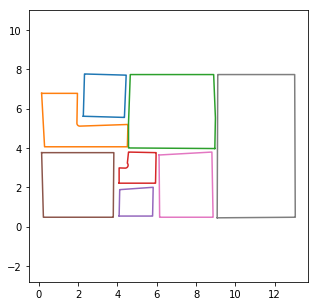

In [120]:
# Filter polygon checks
poly_sh_arr = [copy(p) for p in _poly_sh_arr]
unscaled_poly_sh_arr = [copy(p) for p in _poly_sh_arr]
poly_sh_arr = i2v.move_poly_sh_arr(poly_sh_arr)
poly_sh_arr = [affinity.scale(p, meter_scale, meter_scale, origin=(0, 0)) for p in poly_sh_arr]

n_poly_sh = len(poly_sh_arr)
ridx = i2v.poly_sh_rtree(poly_sh_arr)
print('num @', n_poly_sh)

# TODO: set scale tol
gap_tol = 1.0 #* image_scale
poly_sh_arr = i2v.filter_duplicate_polys(ridx, poly_sh_arr, gap_tol)
_dup_diff = n_poly_sh - len(poly_sh_arr)
print('Removed:', _dup_diff, 'duplicates; num @', len(poly_sh_arr))

area_tol, side_tol = 2, 1
poly_sh_arr = i2v.filter_by_size(poly_sh_arr, area_tol, side_tol, 1)
_sml_diff = n_poly_sh - _dup_diff - len(poly_sh_arr)
print('Removed:', _sml_diff, 'smalls; num @', len(poly_sh_arr))

poly_sh_arr = i2v.filter_parent_polys(poly_sh_arr, 1)
_par_diff = n_poly_sh - _sml_diff - len(poly_sh_arr)
print('Removed:', _par_diff, 'parents; num @', len(poly_sh_arr))

print('num: ', len(poly_sh_arr))
_, a = plt.subplots(figsize=figsize_default)
_ = i2v.viz_poly_sh_arr(poly_sh_arr, a=a)


x comp: 6, y comp: 5


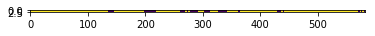

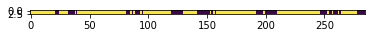

In [121]:
random_seed = 111 
xproj_, yproj_ = i2v.xy_projection(unscaled_poly_sh_arr)
xproj, yproj = i2v.xy_projection(poly_sh_arr)

# Calculate cluster number for x/y axis
gap_tol = 0.5 * image_scale
x_ncomps, y_ncomps = i2v.estimate_1d_cluster_num(xproj_, yproj_, gap_tol, True)
print('x comp: {}, y comp: {}'.format(x_ncomps, y_ncomps))

_poly_sh_arr = poly_sh_arr


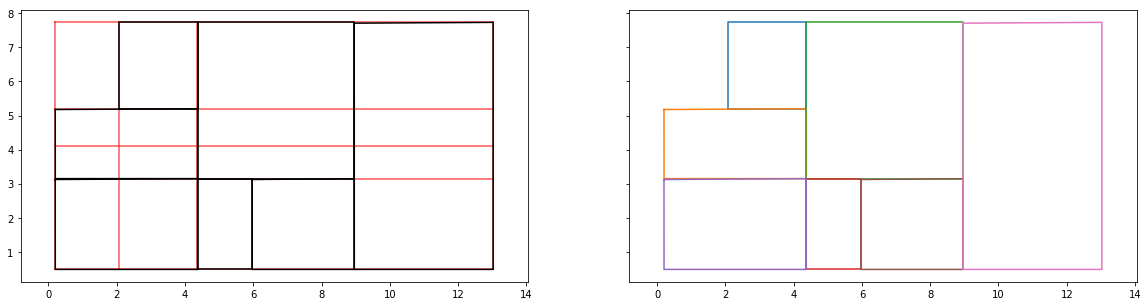

In [167]:
poly_sh_arr = [copy(p) for p in _poly_sh_arr]

# swap axis on yproj to be on xaxis
_FLIP_ORTHO2D_MTX = np.array([[0, 1], [1, 0]])
yproj_swap = yproj @ _FLIP_ORTHO2D_MTX

#tol = 25.0  # door width
#tar_var = (tol / 2) ** 2 
init_var = 2.0     
x_gauss_mod = i2v.gauss_mixture_1d(xproj, x_ncomps, init_var, random_seed)
y_gauss_mod = i2v.gauss_mixture_1d(yproj_swap, y_ncomps, init_var, random_seed)

# Get clusters
x_means = x_gauss_mod.means_[:, 0]
y_means = y_gauss_mod.means_[:, 0]

# Visualize grid 
f, a = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
a[0] = i2v.viz_ortho_snap_grid(x_means, y_means, a[0])
a[0] = i2v.viz_poly_sh_arr(poly_sh_arr, a=a[0], color='black', linewidth=1.5)
# img = hdata['image'].permute(1, 2, 0) / 255.0
_ = a[0].axis('equal')

_cluster_fx = i2v.get_cluster_coord_fx(x_gauss_mod, y_gauss_mod)
buff_eps, simple_tol, diff_pct = 1, 0.5, 0.05
poly_sh_arr_ = []
for poly_sh in poly_sh_arr:
    
    poly_np = _cluster_fx(i2v.to_poly_np(poly_sh).T)
    polyc_sh = i2v.to_poly_sh(poly_np)
    polyc_sh = i2v.clean_poly_sh(polyc_sh, buff_eps, simple_tol, diff_pct)
    
    if polyc_sh is None or polyc_sh.area < 1e-10 or polyc_sh.exterior is None:
        continue    
    poly_sh_arr_.append(polyc_sh)
    
#print(i2v.to_poly_np(poly_sh_arr_[0]))
a[1] = i2v.viz_poly_sh_arr(poly_sh_arr_, a=a[1])
a[1].axis('equal')

poly_sh_arr = poly_sh_arr_

In [168]:

# Scale and shift
# TODO: do this at the beginning after doors. 

_poly_sh_arr = [copy(p) for p in poly_sh_arr]

# ps = _poly_sh_arr[0]
# pn = i2v.to_poly_np(ps)
# print(pn.T)
# ps = ps.simplify(0.5, preserve_topology=False)
# pn = i2v.to_poly_np(ps)
# print(pn.T)

# _ = plt.plot(*pn, marker='o')
#i2v.viz_poly_sh_arr(_poly_sh_arr, marker='o')

# # Dump polygons as numpy arrays
# floorplan_id = hdata['folder'].split('/')[2]
# floorplan_id = 'floorplan_{}'.format(floorplan_id)
# deeprad_model_dir = os.path.abspath(os.path.join(os.getcwd(), '../..', 'deeprad/data/models/'))

# for i, poly_np in enumerate(poly_np_arr):
#     deeprad_fpath = os.path.join(
#         deeprad_model_dir, floorplan_id, '{}_{}.npy'.format(floorplan_id, i))
#     np.save(deeprad_fpath, poly_np)





[[2.07114952 5.20114952]
 [4.36885048 5.20114952]
 [4.36885048 7.72885048]
 [2.07114952 7.72885048]
 [2.07114952 5.20114952]]
[[2.07114952 5.20114952]
 [2.07114952 7.72885048]
 [4.36885048 7.72885048]
 [4.36885048 5.20114952]
 [2.07114952 5.20114952]]
